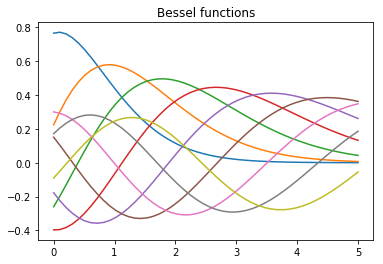

In [1]:
# 绘图案例 an example of matplotlib
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jn
from IPython.display import display, clear_output
import time
x = np.linspace(0,5)
f, ax = plt.subplots()
ax.set_title("Bessel functions")

for n in range(1,10):
    time.sleep(1)
    ax.plot(x, jn(x,n))
    clear_output(wait=True)
    display(f)

# close the figure at the end, so we don't get a duplicate
# of the last plot
plt.close()

In [3]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy import sparse
import warnings
import time
import sys
import os
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth',100)

In [4]:
train = pd.read_csv('../data/jinnan_round1_train_20181227.csv', encoding = 'gb18030')
test  = pd.read_csv('../data/jinnan_round1_testA_20181227.csv', encoding = 'gb18030')

In [5]:
# 删除类别唯一的特征
for df in [train, test]:
    df.drop(['B3', 'B13', 'A13', 'A18', 'A23'], axis=1, inplace=True)

In [6]:
# 删除缺失率超过90%的列
good_cols = list(train.columns)
for col in train.columns:
    rate = train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        good_cols.remove(col)

In [7]:
train = train[good_cols]
good_cols.remove('收率')
test  = test[good_cols]

In [8]:
# 合并数据集
target = train['收率']
del train['收率']
data = pd.concat([train,test],axis=0,ignore_index=True)
data = data.fillna(-1)

In [9]:
# 日期中有些输入错误和遗漏
def t2s(t):
    try:
        t,m,s=t.split(":")
    except:
        if t=='1900/1/9 7:00':
            return 7*3600
        elif t=='1900/1/1 2:30':
            return 2*3600+30*60
        elif t==-1:
            return -1
        else:
            return 0
    
    try:
        tm = int(t)*3600+int(m)*60+int(s)
    except:
        return 30*60
    
    return tm
for f in ['A5','A7','A9','A11','A14','A16','A24','A26','B5','B7']:
    data[f] = data[f].apply(t2s)

def getDuration(se):
    try:
        sh,sm,eh,em=re.split("[:,-]",se)
    except:
        if se=='14::30-15:30':
            return 3600
        elif se=='13；00-14:00':
            return 3600
        elif se=='21:00-22；00':
            return 3600
        elif se=='22"00-0:00':
            return 7200
        elif se=='2:00-3;00':
            return 3600
        elif se=='1:30-3;00':
            return 5400
        elif se=='15:00-1600':
            return 3600
        elif se==-1:
            return -1
        else:
            return 30*60
        
    try:
        tm = int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600
    except:
        if se=='19:-20:05':
            return 3600
        else:
            return 30*60
    
    return tm
for f in ['A20','A28','B4','B9','B10','B11']:
    data[f] = data.apply(lambda df: getDuration(df[f]), axis=1)

In [10]:
cate_columns = [f for f in data.columns if f != '样本id']

In [11]:
#label encoder
for f in cate_columns:
    data[f] = data[f].map(dict(zip(data[f].unique(), range(0, data[f].nunique()))))
train = data[:train.shape[0]]
test  = data[train.shape[0]:]

In [12]:
train['target'] = target
train['outliers'] = 0
train.loc[train['target'] < 0.9, 'outliers'] = 1
train['outliers'].value_counts()
for f in cate_columns:
    colname = f+'_outliers_mean'
    order_label = train.groupby([f])['outliers'].mean()
    for df in [train, test]:
        df[colname] = df[f].map(order_label)

In [13]:
train.drop(['样本id','target','outliers'], axis=1, inplace=True)
test = test[train.columns]
X_train = train.values
y_train = target.values
X_test = test.values

In [14]:
param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, target)))

fold n°1
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000331309	valid_1's l2: 0.00025193
[400]	training's l2: 0.000260595	valid_1's l2: 0.000224623
[600]	training's l2: 0.000231872	valid_1's l2: 0.000218531
[800]	training's l2: 0.00021316	valid_1's l2: 0.00021811
Early stopping, best iteration is:
[735]	training's l2: 0.000218536	valid_1's l2: 0.000217854
fold n°2
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000269826	valid_1's l2: 0.000616874
[400]	training's l2: 0.0002101	valid_1's l2: 0.000567659
[600]	training's l2: 0.000185392	valid_1's l2: 0.000547771
[800]	training's l2: 0.00017117	valid_1's l2: 0.000535302
[1000]	training's l2: 0.000161694	valid_1's l2: 0.000528795
[1200]	training's l2: 0.000154553	valid_1's l2: 0.000523131
[1400]	training's l2: 0.000148446	valid_1's l2: 0.000519941
[1600]	training's l2: 0.000143356	valid_1's l2: 0.000516881
[1800]	training's l2: 0.000139112	valid_1's l2: 0.000514

In [15]:
##### xgb
xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, target)))

fold n°1
[0]	train-rmse:0.421989	valid_data-rmse:0.423326
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.256626	valid_data-rmse:0.257287
[200]	train-rmse:0.156625	valid_data-rmse:0.156968
[300]	train-rmse:0.096207	valid_data-rmse:0.096617
[400]	train-rmse:0.059816	valid_data-rmse:0.060802
[500]	train-rmse:0.038047	valid_data-rmse:0.040011
[600]	train-rmse:0.025193	valid_data-rmse:0.028417
[700]	train-rmse:0.017698	valid_data-rmse:0.022389
[800]	train-rmse:0.013366	valid_data-rmse:0.019431
[900]	train-rmse:0.01094	valid_data-rmse:0.01801
[1000]	train-rmse:0.00955	valid_data-rmse:0.01738
[1100]	train-rmse:0.008735	valid_data-rmse:0.017069
[1200]	train-rmse:0.008187	valid_data-rmse:0.016919
[1300]	train-rmse:0.007803	valid_data-rmse:0.016853
[1400]	train-rmse:0.007505	valid_data-rmse:0.01685
[1500]	train-rmse:0.007275	valid_data-rmse:0.016862
Stopping. Best itera

In [16]:
# 将lgb和xgb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
mean_squared_error(target.values, oof_stack)

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.00029147041025009962

In [17]:
sub_df = pd.read_csv('../data/jinnan_round1_submit_20181227.csv', header=None)
sub_df[1] = predictions
sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))
sub_df.to_csv("../data/submit1.csv", index=False, header=None)